# Manufacturing Defect Analysis — Cleaned Notebook

#### Project title

### Manufacturing Defect Prediction & Repair Cost Estimation

### Objective:

##### Build a classification model to predict DefectStatus (binary) and interpret drivers (Logistic Regression).

##### Build a regression model to predict repair_cost (continuous) where appropriate.

##### Dataset: manufacturing_defect.csv. 

1. ### Setup & Imports

In [16]:
import sys
from pathlib import Path

# Add src folder to the Python path
sys.path.append(str(Path('../src').resolve()))

# Importing modules directly
from feature_engineering import drop_leaky_features, detect_leakage, split_X_y
from model_training import train_pipeline, evaluate, save_model, build_preprocessor
from model_evaluation import build_importance_df

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns


# Modeling imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error, r2_score


# Stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


# Visual settings
sns.set(style='whitegrid')
%matplotlib inline

2. ### Load data

In [3]:
df = pd.read_csv('../data/interim/cleaned_data.csv')
m_df = df.copy()

print('Shape:', m_df.shape)
m_df.head()

Shape: (3240, 17)


,ProductionVolume,ProductionCost,SupplierQuality,DeliveryDelay,DefectRate,QualityScore,MaintenanceHours,DowntimePercentage,InventoryTurnover,StockoutRate,WorkerProductivity,SafetyIncidents,EnergyConsumption,EnergyEfficiency,AdditiveProcessTime,AdditiveMaterialCost,DefectStatus
0,202,13175.403783,86.648534,1,3.121492,63.463494,9,0.052343,8.630515,0.081322,85.042379,0,2419.616785,0.468947,5.551639,236.439301,1
1,535,19770.046093,86.310664,4,0.819531,83.697818,20,4.908328,9.296598,0.038486,99.657443,7,3915.566713,0.119485,9.080754,353.957631,1
2,960,19060.820997,82.132472,0,4.514504,90.350550,1,2.464923,5.097486,0.002887,92.819264,2,3392.385362,0.496392,6.562827,396.189402,1
3,370,5647.606037,87.335966,5,0.638524,67.628690,8,4.692476,3.577616,0.055331,96.887013,8,4652.400275,0.183125,8.097496,164.135870,1
4,206,7472.222236,81.989893,3,3.867784,82.728334,9,2.746726,6.851709,0.068047,88.315554,7,1581.630332,0.263507,6.406154,365.708964,1


3. ### Quick EDA

In [4]:
# Basic info
m_df.info()

# Descriptive stats
m_df.describe(include='all').T

# Check for missing values
m_df.isna().sum()

# Cardinality
m_df.nunique().sort_values(ascending=False)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3240 entries, 0 to 3239
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ProductionVolume      3240 non-null   int64  
 1   ProductionCost        3240 non-null   float64
 2   SupplierQuality       3240 non-null   float64
 3   DeliveryDelay         3240 non-null   int64  
 4   DefectRate            3240 non-null   float64
 5   QualityScore          3240 non-null   float64
 6   MaintenanceHours      3240 non-null   int64  
 7   DowntimePercentage    3240 non-null   float64
 8   InventoryTurnover     3240 non-null   float64
 9   StockoutRate          3240 non-null   float64
 10  WorkerProductivity    3240 non-null   float64
 11  SafetyIncidents       3240 non-null   int64  
 12  EnergyConsumption     3240 non-null   float64
 13  EnergyEfficiency      3240 non-null   float64
 14  AdditiveProcessTime   3240 non-null   float64
 15  AdditiveMaterialCost 

ProductionCost          3240
AdditiveMaterialCost    3240
SupplierQuality         3240
DefectRate              3240
QualityScore            3240
InventoryTurnover       3240
DowntimePercentage      3240
WorkerProductivity      3240
StockoutRate            3240
EnergyConsumption       3240
AdditiveProcessTime     3240
EnergyEfficiency        3240
ProductionVolume         862
MaintenanceHours          24
SafetyIncidents           10
DeliveryDelay              6
DefectStatus               2
dtype: int64

```
** Notes: **

* Identify which columns are numeric vs categorical.
* If date columns exist, convert to datetime and extract features (month, day, weekday).

```

In [5]:
# Example date handling
if 'DefectDate' in m_df.columns:
    m_df['DefectDate'] = pd.to_datetime(m_df['defect_date'], errors='coerce')
    m_df['DefectMonth'] = m_df['defect_date'].dt.month
    m_df['DefectWeekday'] = m_df['defect_date'].dt.weekday
    # drop the raw date if not needed
    m_df = m_df.drop(columns=['defect_date'])

4. #### checking for multicolinearity

<Axes: >

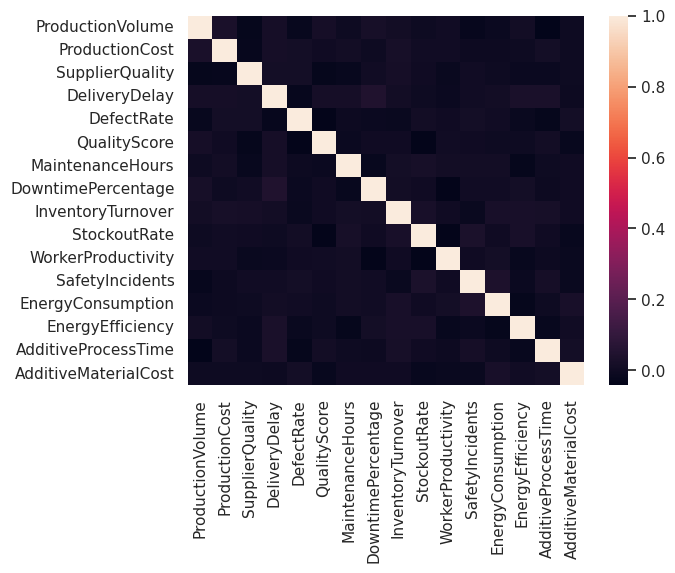

In [6]:
correlation = m_df.select_dtypes('number').drop(columns='DefectStatus').corr()

# plot heatmap
sns.heatmap(correlation)

#### Seems we where unable to detect any multicolinearity in our heatmap above

### 5.  Leak detection and feature selections

In [7]:
# If a column perfectly determines it target, it is leaky(we will drop it)

leaky_cols = detect_leakage(df, 'DefectStatus')
print("Potential leaky columns:", leaky_cols)

print(m_df[leaky_cols].corr())

# categorical or discrete leaks that correlation won’t detect: this is a post production features

# Defect rate against defect status
print((m_df.groupby("DefectRate")["DefectStatus"].nunique() == 1).all())

# Quality Score agains defect status
print((m_df.groupby("QualityScore")["DefectStatus"].nunique() == 1).all())

# checking for indirect leakage
print(m_df.corr()["DefectStatus"].sort_values(ascending=False))




Potential leaky columns: []
Empty DataFrame
Columns: []
Index: []
True
True
DefectStatus            1.000000
MaintenanceHours        0.297107
DefectRate              0.245746
ProductionVolume        0.128973
StockoutRate            0.040574
SupplierQuality         0.038184
ProductionCost          0.026720
InventoryTurnover       0.006733
AdditiveProcessTime     0.005619
DeliveryDelay           0.005425
EnergyConsumption       0.005039
DowntimePercentage      0.004128
AdditiveMaterialCost   -0.000953
WorkerProductivity     -0.005224
SafetyIncidents        -0.016039
EnergyEfficiency       -0.035031
QualityScore           -0.199219
Name: DefectStatus, dtype: float64


In [8]:
# we will be droping QualityScore, DefectRate, as they have shown to be leaky features
leaky_cols = ["QualityScore",  "DefectRate"]
m_df = drop_leaky_features(m_df, leaky_cols)

Dropping leaky column: QualityScore
Dropping leaky column: DefectRate


### 6. Prepare features: split into X, y then train/ test

In [9]:
classification_target = 'DefectStatus'

# Drop Id column if exists
drop_cols = [c for c in ['defect_id'] if c in m_df.columns]

# Drop those columns from the dataframe
m_df = m_df.drop(columns=drop_cols)

# Split into X and y
X, y = split_X_y(m_df, classification_target)

# sanity
print("Features used: ", X.shape[1])
print("Sample: ", X.shape[0])


# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Features used:  14
Sample:  3240


### 7. Identify numeric and categorical columns

In [10]:
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("Numeric:", numeric_cols)
print("Categorical:", cat_cols)

Numeric: ['ProductionVolume', 'ProductionCost', 'SupplierQuality', 'DeliveryDelay', 'MaintenanceHours', 'DowntimePercentage', 'InventoryTurnover', 'StockoutRate', 'WorkerProductivity', 'SafetyIncidents', 'EnergyConsumption', 'EnergyEfficiency', 'AdditiveProcessTime', 'AdditiveMaterialCost']
Categorical: []


##### if some  numerics columns are actually categorical(small numbers of unique values)

In [11]:
for col in numeric_cols.copy():
    if X_train[col].nunique() < 20:
        cat_cols.append(col)
        numeric_cols.remove(col)
        

print("Adjusted Numeric:", numeric_cols)
print("Adjusted Categorical:", cat_cols)

Adjusted Numeric: ['ProductionVolume', 'ProductionCost', 'SupplierQuality', 'MaintenanceHours', 'DowntimePercentage', 'InventoryTurnover', 'StockoutRate', 'WorkerProductivity', 'EnergyConsumption', 'EnergyEfficiency', 'AdditiveProcessTime', 'AdditiveMaterialCost']
Adjusted Categorical: ['DeliveryDelay', 'SafetyIncidents']


### 8. Build Preprocessing pipeline


In [12]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ],
    remainder='drop'
)

### 9 Logistic Regression (Classification)

Train Acc:  0.691
Test Acc:  0.6836

Classification report (test):
              precision    recall  f1-score   support

           0       0.28      0.64      0.39       103
           1       0.91      0.69      0.79       545

    accuracy                           0.68       648
   macro avg       0.60      0.67      0.59       648
weighted avg       0.81      0.68      0.72       648



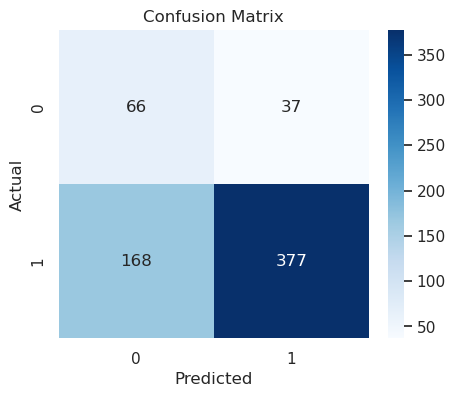

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=3000, random_state=42, class_weight='balanced'))
]).fit(X_train, y_train)

# Evaluate
y_pred_train = clf_model.predict(X_train)
y_pred_test = clf_model.predict(X_test)

print("Train Acc: ", round(accuracy_score(y_train, y_pred_train), 4))
print("Test Acc: ", round(accuracy_score(y_test, y_pred_test), 4))
print('\nClassification report (test):')
print(classification_report(y_test, y_pred_test))

# Confusion MatrixP
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### 10. Features names & coefficients -> importance & odds ratio

In [14]:
# Get Transformed feature names
feature_names = clf_model.named_steps['preprocessor'].get_feature_names_out()
coefs = clf_model.named_steps['classifier'].coef_[0]

importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs
}).sort_values(by='Coefficient', ascending=False)

importance['Odds_Ratio'] = np.exp(importance['Coefficient'])

#  Sort by magnitude or odds ratio
importance = importance.sort_values(by='Odds_Ratio', ascending=True).reset_index(drop=True)
print(importance)

# set index for plotting
importance.set_index('Feature', inplace=True)
importance.head()

                      Feature  Coefficient  Odds_Ratio
0        cat__DeliveryDelay_2    -0.188384    0.828296
1      cat__SafetyIncidents_9    -0.141988    0.867631
2      cat__SafetyIncidents_6    -0.086965    0.916709
3       num__EnergyEfficiency    -0.083446    0.919940
4      cat__SafetyIncidents_2    -0.061447    0.940403
5      cat__SafetyIncidents_7    -0.055167    0.946327
6     num__WorkerProductivity    -0.046027    0.955016
7        cat__DeliveryDelay_1    -0.028661    0.971746
8     num__DowntimePercentage     0.004508    1.004519
9      num__InventoryTurnover     0.008815    1.008854
10  num__AdditiveMaterialCost     0.020717    1.020933
11   num__AdditiveProcessTime     0.021918    1.022160
12     cat__SafetyIncidents_0     0.022598    1.022855
13     cat__SafetyIncidents_8     0.029626    1.030069
14     cat__SafetyIncidents_1     0.031053    1.031540
15     cat__SafetyIncidents_3     0.040290    1.041112
16        num__ProductionCost     0.041791    1.042676
17     num

,Coefficient,Odds_Ratio
Feature,,
cat__DeliveryDelay_2,-0.188384,0.828296
cat__SafetyIncidents_9,-0.141988,0.867631
cat__SafetyIncidents_6,-0.086965,0.916709
num__EnergyEfficiency,-0.083446,0.919940
cat__SafetyIncidents_2,-0.061447,0.940403


#### plot odds Ratio


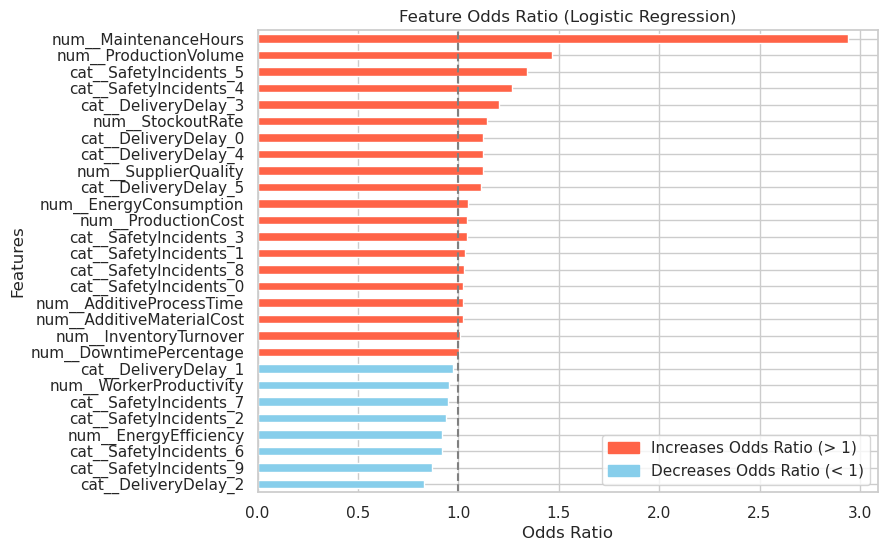

In [17]:
plt.figure(figsize=(8, 6))
colors = ['tomato' if x > 1 else 'skyblue' for x in importance['Odds_Ratio']]
importance['Odds_Ratio'].plot(kind='barh', color=colors)
plt.axvline(x=1, color='gray', linestyle='--', label='Odds Ratio = 1')
red_papatch = mpatches.Patch(color='tomato', label='Increases Odds Ratio (> 1)')
blue_patch = mpatches.Patch(color='skyblue', label='Decreases Odds Ratio (< 1)')
plt.legend(handles=[red_papatch, blue_patch], loc='lower right')
plt.xlabel('Odds Ratio')
plt.ylabel('Features')
plt.title('Feature Odds Ratio (Logistic Regression)')
plt.show()